# Classification Overview
* Methods overview
* Data preparation and DNN


# Libs

In [2]:
import os
import re
import sys
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time   
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (classification_report, confusion_matrix, \
                             roc_curve, roc_auc_score, precision_score, recall_score)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
 
from fitter import Fitter, get_common_distributions, get_distributions

from collections import Counter
import missingno as mn 
import random
from copy import deepcopy 

from sklearn import ensemble 
from sklearn import tree  
from sklearn import kernel_ridge

from sklearn.preprocessing import scale

from sklearn import linear_model 
from sklearn import decomposition
from sklearn import svm 
import catboost  
import lightgbm 

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score,confusion_matrix, accuracy_score
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection 

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV 

from scipy.stats import pearsonr 
from dtaidistance import dtw, dtw_ndim
from kneed import DataGenerator, KneeLocator
from  sklearn.feature_selection import VarianceThreshold

from statsmodels.tsa.stattools import adfuller 
from scipy.fft import fft, ifft
from IPython.display import display, Markdown, Image

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks
  
import warnings
warnings.simplefilter("ignore")

# Load Data

In [3]:
current = os.getcwd() 

parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
 
PROJECT_PATH = os.getcwd() + "/gifs"  
current = os.getcwd() 
parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.insert(0, f"{parent_folder}\Classes") # 
from menu_A_a_data_utility import DataUtility 
#from memu_D_features import SelectingEDAFeatures

def load_data(flags = None):
    uti = DataUtility()
    df_train, df_test, df_result = uti.prepare_dfs()
    df_train["rul"] = df_train.groupby(["Flag","id"])["cycle"].transform("max")-df_train["cycle"]
    
    if not flags:
        return df_train, df_test, df_result
    if type(flags) == str:
        flags = [flags] #list 
    return df_train[df_train["Flag"].isin(flags)],df_test[df_test["Flag"].isin(flags)],df_result[df_result["Flag"].isin(flags)]

DF_TRAIN, DF_TEST, DF_RESULT = load_data(flags = "FD001") 

train,test,result = DF_TRAIN.copy(), DF_TEST.copy(), DF_RESULT.copy() 

In [18]:
type(result), result.shape
abc = "tomorrow"
type(abc)

if 1 == 124:
    if isinstance(abc, str): 
        print("this is string")
    else:
        print("noooooo")
    
result.loc[1, "Flag"]
result.iloc[:, 2:].head(2)

,id,cycle,rul_failed
0,1,31,143
1,2,49,147


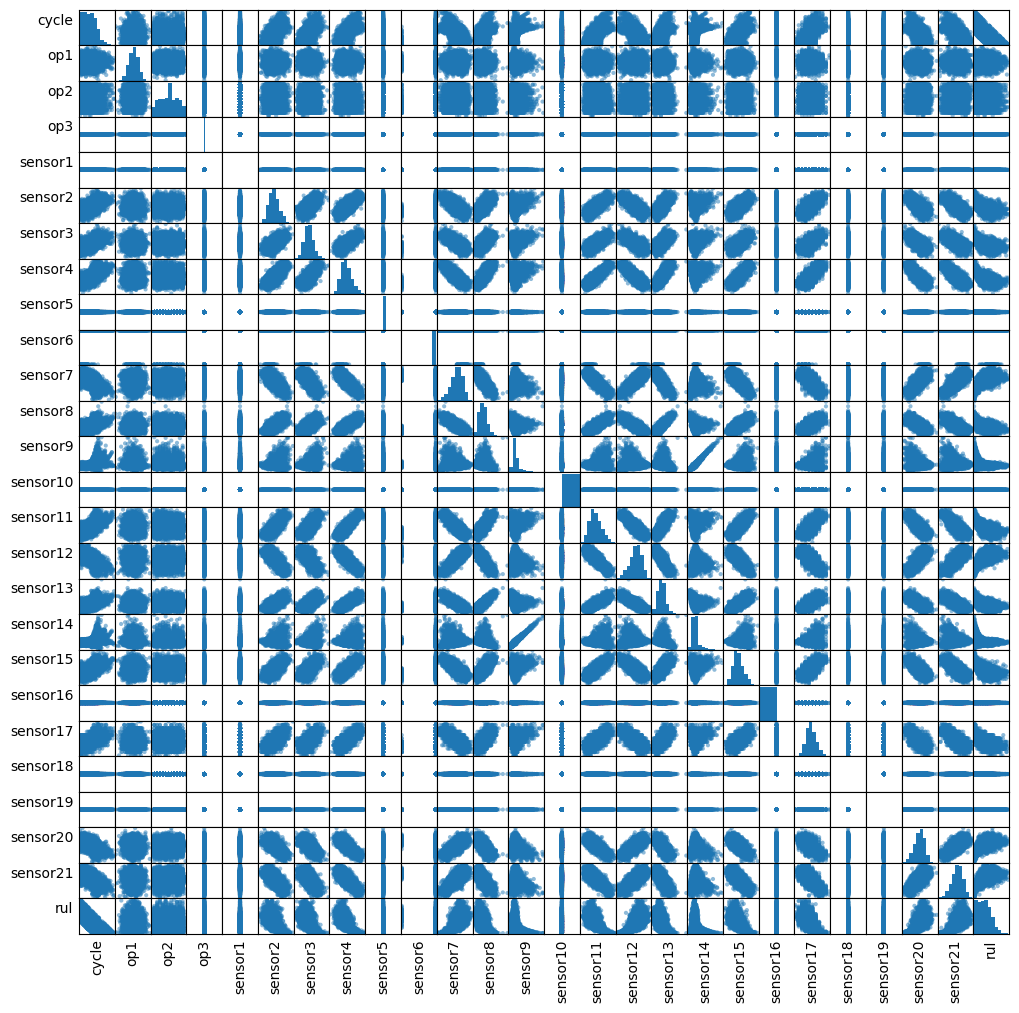

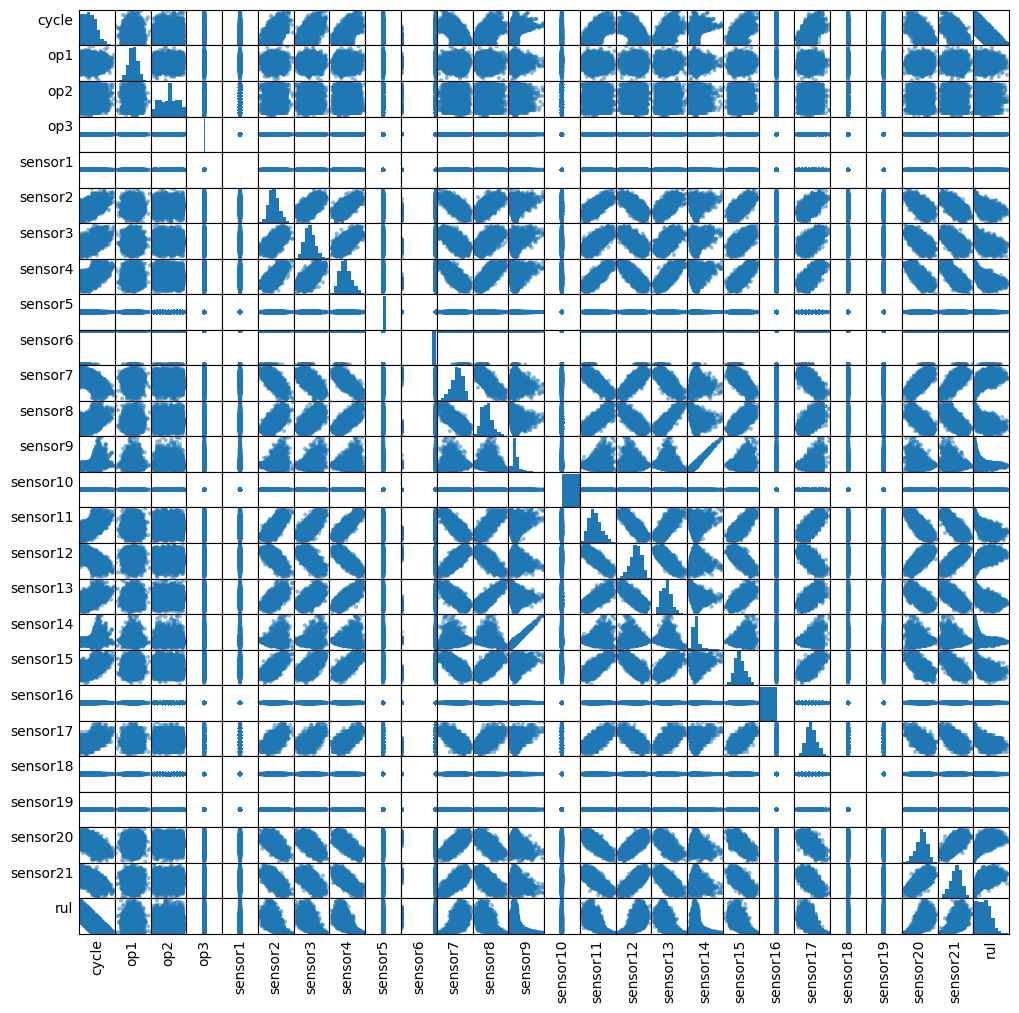

In [20]:
tmp = train.drop(columns=["Flag", "id"]).sample(frac=0.2)
axes = pd.plotting.scatter_matrix(tmp, figsize=(12,12))
num_cols = tmp.shape[1]

for col in range(num_cols):
    ax = axes[col, 0]
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha("right")
    ax.set_yticks(())
    h = axes[num_cols-1, col]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())
plt.show()


## Label 

In [32]:
CYCLE = 50 
outputs = [1 if ii<CYCLE else 0 for ii in train["rul"]]
outputs2 = Counter(outputs)
outputs2.most_common(2)

[(0, 15631), (1, 5000)]

In [37]:
CYCLE = 50 

train = DF_TRAIN.copy() #deepcopy 
test = DF_TEST.copy()

train["label"] = [1 if i<CYCLE else 0 for i in train["rul"]] 
test["label"] = [1 if i<CYCLE else 0 for i in test["remaining_rul"]] 
y = train.iloc[:, -1:].values 
ytest = test.iloc[:, -1:].values

train.drop(columns=["Flag", "id", "cycle", "rul", "label"], inplace=True)
test.drop(columns=["Flag", "id", "cycle", "remaining_rul", "rul_failed","label"], inplace=True)

In [43]:
X = train.iloc[:, :-1].values  
Xtest  = test.iloc[:, :-1].values 

## Scale 

In [45]:
minscaler = MinMaxScaler()
X = minscaler.fit_transform(X) 
Xtest = minscaler.transform(Xtest)

(20631, 23)

## Practice

# Classification algorithms
* Naive Bayes Classifier 
* Decision Tree
* Random Forests
* Support Vector Machines
* K-Nearest Neighbour 
* Deep Neural


In [48]:
[c for c in list(DF_TRAIN) if re.match('sensor',c)]

['sensor1',
 'sensor2',
 'sensor3',
 'sensor4',
 'sensor5',
 'sensor6',
 'sensor7',
 'sensor8',
 'sensor9',
 'sensor10',
 'sensor11',
 'sensor12',
 'sensor13',
 'sensor14',
 'sensor15',
 'sensor16',
 'sensor17',
 'sensor18',
 'sensor19',
 'sensor20',
 'sensor21']

In [49]:
def prepare_data(CYCLE = 50, sequence_length = 12): 
    
    train,test,result = DF_TRAIN.copy(), DF_TEST.copy(), DF_RESULT.copy() 
    
    train["label"] = [1 if i<CYCLE else 0 for i in train["rul"]]
    test["label"] = [1 if i<CYCLE else 0 for i in test["remaining_rul"]]
    min_max_scaler = MinMaxScaler(feature_range=(-1,1))
    FEATS = [c for c in list(train) if re.match('sensor',c)] 
    feats = deepcopy(FEATS) 

    train[feats] = min_max_scaler.fit_transform(train[feats])
    test[feats] = min_max_scaler.transform(test[feats])
    
    return train, test, feats

In [50]:
train, test, feats = prepare_data()

## 1. Naive Bayes Classifier

Naive Bayes classifier, is one of the simplest and most effective classification machine learning algorithms. Its basis is Bayes' theorem which describes how the probability of an event is evaluated based on prior knowledge of conditions that might be related to the event. Mathematically, this theorem states-

$ \text{P}\left ( Y|X\right )=\frac{P\left ( X|Y\right )P\left ( Y\right )}{P\left ( X\right )} $

* Important: 
It assumes independence among feature variables which may not always be the case

Implementations in SKlearn
* sklearn.naive_bayes: Naive Bayes

1. naive_bayes.BernoulliNB  Naive Bayes classifier for multivariate Bernoulli models.
2. naive_bayes.CategoricalNB Naive Bayes classifier for categorical features.
3. naive_bayes.ComplementNB The Complement Naive Bayes classifier described in Rennie et al. (2003).
4. naive_bayes.GaussianNB Gaussian Naive Bayes (GaussianNB).
5. naive_bayes.MultinomialNB Naive Bayes classifier for multinomial models.

* Use GaussianNB: class sklearn.naive_bayes.GaussianNB(*, priors=None, var_smoothing=1e-09) 
* only two parameters. If priors are set, then wont adjust

In [52]:
from sklearn.naive_bayes import GaussianNB
X = train[feats]
Y = train["label"]
clf = GaussianNB()
clf.fit(X, Y) 
clf.score(X, Y)
predictions = clf.predict(test[feats]) #, test["label"]

confusion_matrix(predictions, test["label"])  
print(classification_report(predictions, test["label"]))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     11918
           1       0.79      0.57      0.67      1178

    accuracy                           0.95     13096
   macro avg       0.88      0.78      0.82     13096
weighted avg       0.94      0.95      0.94     13096



### practice

In [ ]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X,y) #拟合 
pred = clf.predict(test[feats])
print(classification_report(pred, test["label"]))

## 2. Tree
* tree.DecisionTreeClassifier
* tree.ExtraTreeClassifier

* es.g: ExtraTreeClassifier(*, criterion='gini', splitter='random', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
* ( there is also from sklearn.ensemble import ExtraTreesClassifier)

* difference between RF and extra tree is random forest uses bootstrap replicas, that is to say, it subsamples the input data with replacement, whereas Extra Trees use the whole original sample. RF use bagging

In [63]:
from sklearn.tree import ExtraTreeClassifier

In [64]:
X = train[feats]
Y = train["label"]
cls = ExtraTreeClassifier()
clf.fit(X, Y)
score = clf.score(X, Y)
print("Score: ", score)
cv_scores = cross_val_score(clf, X, Y, cv=5 )
print("CV average score: %.2f" % cv_scores.mean())
predictions = clf.predict(test[feats])

print(classification_report(test["label"], predictions))

print('\n')

print(f1_score(test["label"], predictions))

Score:  0.9117347680674713
CV average score: 0.91
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     12243
           1       0.63      0.68      0.66       853

    accuracy                           0.95     13096
   macro avg       0.81      0.83      0.82     13096
weighted avg       0.96      0.95      0.95     13096



0.6557377049180328


## 3. Ensemble. E.g.Random Forests Classification Algorithm
* A forest consists of a large number of trees. Similarly, a random forest involves processing many decision trees. Each tree predicts a value for the probability of target variables. We then average the probabilities to produce the final output. 

* it is one ensemble method

1. ensemble.AdaBoostClassifier. An AdaBoost classifier. 
2. ensemble.BaggingClassifier. A Bagging classifier. 
3. ensemble.ExtraTreesClassifier An extra-trees classifier  
4. ensemble.GradientBoostingClassifier Gradient Boosting for classifier
5. ensemble.StackingClassifier Stack of estimators with a final classifier. 
6. ensemble.StackingRegressor Stack of estimators with a final regressor.
7. ensemble.VotingClassifier Soft Voting/Majority Rule classifier for unfitted estimators. 

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier

estimators = [
('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
('ada', AdaBoostClassifier(n_estimators=10, random_state=42))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
 
X = train[feats]
Y = train["label"]

clf.fit(X, Y).score(X, Y) 
print("stacking model: ", score)

predictions = clf.predict(test[feats])
print(classification_report(test["label"], predictions))

stacking model:  0.9117347680674713
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     12243
           1       0.80      0.61      0.70       853

    accuracy                           0.97     13096
   macro avg       0.89      0.80      0.84     13096
weighted avg       0.96      0.97      0.96     13096



## 4. Support Vector Machines (SVMs)
* It performs well when the data is high-dimensional.
* Caution: 
    1. It is sensitive to kernel functions, so they have to be chosen wisely.
    2. week in handling noise
     
1. svm.LinearSVC Linear Support Vector Classification. 
2. svm.NuSVC  Nu-Support Vector Classification. 
3. svm.OneClassSVM Unsupervised Outlier Detection. 
4. svm.SVC C-Support Vector Classification.
 

In [66]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC

X = train[feats]
Y = train["label"]
 
clf = make_pipeline(StandardScaler(), LinearSVC()) 
score = clf.fit(X, Y).score(X, Y) 
print("stacking model: ", score)

predictions = clf.predict(test[feats])
print(classification_report(test["label"], predictions))


stacking model:  0.9324317774223256
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     12243
           1       0.81      0.61      0.70       853

    accuracy                           0.97     13096
   macro avg       0.89      0.80      0.84     13096
weighted avg       0.96      0.97      0.96     13096



## 5. K-Nearest Neighbour Classification Algorithm
* KNN algorithm works by identifying K nearest neighbors to a given observation point
* sklearn sklearn.neighbors
1. neighbors.KNeighborsClassifier Classifier implementing the k-nearest neighbors vote.
2. neighbors.KNeighborsRegressor Regression based on k-nearest neighbors. 
3. neighbors.LocalOutlierFactor Unsupervised Outlier Detection using the Local Outlier Factor (LOF).
4. neighbors.RadiusNeighborsClassifier Classifier implementing a vote among neighbors within a given radius. 
5. neighbors.NearestCentroid Nearest centroid classifier.

* it applies  to datasets of any distribution.
* caution: It is easily affected by outliers

In [67]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5) # default 5

X = train[feats]
Y = train["label"]

score = neigh.fit(X, Y).score(X, Y) 
print("stacking model: ", score)

predictions = neigh.predict(test[feats])
print(classification_report(test["label"], predictions))
 
# neigh.predict
#print(neigh.predict_proba([[0.9]]))

stacking model:  0.9466337065580922
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     12243
           1       0.76      0.58      0.66       853

    accuracy                           0.96     13096
   macro avg       0.87      0.79      0.82     13096
weighted avg       0.96      0.96      0.96     13096



## 6. other ensembles: 
### xgboost
* xgboost uses boosting: In boosting, the trees are built sequentially such that each subsequent tree aims to reduce the errors of the previous tree.
* rf uses bagging. Bagging is an ensemble algorithm that fits multiple models on different subsets of a training dataset, then combines the predictions from all models.

In [68]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()
 
X = train[feats]
Y = train["label"]
xgb_cl.fit(X, Y)

# Predict
preds = xgb_cl.predict(test[feats])

# Score
accuracy_score(test["label"], preds)

print(classification_report(test["label"], preds)) 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     12243
           1       0.79      0.62      0.70       853

    accuracy                           0.96     13096
   macro avg       0.88      0.81      0.84     13096
weighted avg       0.96      0.96      0.96     13096



### lightgbm.LGBMClassifier
* In XGBoost, trees grow depth-wise while in LightGBM, trees grow leaf-wise
* it is also an ensemble model of decision trees for classification and regression prediction

In [ ]:
train, test, feats = prepare_data()

In [69]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier() 

X = train[feats]
Y = train["label"]
lgbm.fit(X, Y)

# Predict
preds = lgbm.predict(test[feats])

# Score
accuracy_score(test["label"], preds)

print(classification_report(test["label"], preds)) 
print(accuracy_score(test["label"], preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     12243
           1       0.82      0.62      0.70       853

    accuracy                           0.97     13096
   macro avg       0.90      0.80      0.84     13096
weighted avg       0.96      0.97      0.96     13096

0.9663255956017105


### CatBoost 
* name comes from two words “Category” and “Boosting”.
* Also an Ensemble. The same splitting criterion is used across an entire level of the tree. Such trees are balanced, less prone to overfitting, and allow speeding up prediction significantly at testing time.
* Strength. don't need toconvert categorical variables to numerical like in other models.
It grows a balanced tree and can handle missing values

In [70]:
from catboost import CatBoostClassifier

X = train[feats]
Y = train["label"] 

cb = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)


score = cb.fit(X, Y, 
        #cat_features=cat_features, 
        eval_set=(test[feats], test["label"]), 
        verbose=False
).score(X,Y) 

print('CatBoost model is fitted: ' + str(cb.is_fitted()))
print('CatBoost model parameters:')
print(cb.get_params())
print(score)
 
preds = cb.predict(test[feats]) 
accuracy_score(test["label"], preds)

print(classification_report(test["label"], preds)) 
print(accuracy_score(test["label"], preds))


CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'learning_rate': 0.1}
0.934128253598953
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     12243
           1       0.82      0.58      0.68       853

    accuracy                           0.96     13096
   macro avg       0.89      0.79      0.83     13096
weighted avg       0.96      0.96      0.96     13096

0.9642638973732437


## 7. Deep Neural Network
* Deep Neural Network: 
Three following types of deep neural networks are popularly used today: 
1. Multi-Layer Perceptrons (MLP). MLPs models are the most basic deep neural network 
2. Convolutional Neural Networks (CNN) 
3. Recurrent Neural Networks (RNN) 

# Neural Network

### prepare input

In [71]:

current = os.getcwd() 

parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
 
PROJECT_PATH = os.getcwd() + "/gifs"  
current = os.getcwd() 
parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.insert(0, f"{parent_folder}\Classes") # 
from menu_A_a_data_utility import DataUtility 
#from memu_D_features import SelectingEDAFeatures
train,test,result = DF_TRAIN.copy(), DF_TEST.copy(), DF_RESULT.copy() 

def load_data(flags = None):
    uti = DataUtility()
    df_train, df_test, df_result = uti.prepare_dfs()
    df_train["rul"] = df_train.groupby(["Flag","id"])["cycle"].transform("max")-df_train["cycle"]
    
    if not flags:
        return df_train, df_test, df_result
    if type(flags) == str:
        flags = [flags] #list 
    return df_train[df_train["Flag"].isin(flags)],df_test[df_test["Flag"].isin(flags)],df_result[df_result["Flag"].isin(flags)]

DF_TRAIN, DF_TEST, DF_RESULT = load_data(flags = "FD001")  

In [133]:
class lstm_cls():
    from sklearn.preprocessing import MinMaxScaler
    """
        modeling lstm nn 
    """    
    def __init__(self, cycle=50,feats=None, seq_length=12, label="label", mask_value=0):
        """
            set cycle -- threshold for classing
            feats: features. for now set to None
            seq_length: for lstm
        """
        if not feats:
            feats = [c for c in list(DF_TRAIN) if re.match(r'sens', c) ]
        self.feats = feats 
        self.cycle = cycle
        self.seq_length = seq_length 
        self.mask_value = 0 
        self.nb_features = len(feats)  
        self.label = label
        self.mask_value = mask_value 

    def populate_scaling(self, train, test, to_scale = True): 
        """
            scale and populate label
            input: raw training data 
            output: scaled(if choose to) and label populated
        """
        train[self.label] = [1 if i<self.cycle else 0 for i in train["rul"]]
        test[self.label] = [1 if i<self.cycle else 0 for i in test["remaining_rul"]]
        min_max_scaler = MinMaxScaler(feature_range=(-1,1))  
        if to_scale:
            train[self.feats] = min_max_scaler.fit_transform(train[self.feats])
            test[self.feats] = min_max_scaler.transform(test[self.feats])
        return train, test
    
    def gen_train(self, train):
        """
            lstm input tuple: (batch, time steps, features) 
            train = train dataframe
            seq_length is look back period
            
            input: one engine's data 
            output: shape(samples, time step, features)
        """ 
        data_array = train[self.feats].values
        num_elements = data_array.shape[0]
        lstm_array=[]

        for start, stop in zip(range(0, num_elements-self.seq_length+1), range(self.seq_length, num_elements+1)):
            lstm_array.append(data_array[start:stop, :])

        return np.array(lstm_array)
  
    def gen_target(self, y_true):
        """
            input: label array
            engine by engine
        """
        data_array = y_true[self.label].values
        num_elements = data_array.shape[0]
        return data_array[self.seq_length-1:num_elements+1]

    def gen_test(self, test):
        """
            counterpart fun for gen_train. 
            but: only predict latest batch
            engine by engine
        """
        df_mask = pd.DataFrame(np.zeros((self.seq_length-1,test.shape[1])),columns=test.columns)
        df_mask[:] = self.mask_value

        test = df_mask.append(test,ignore_index=True)

        data_array = test[self.feats].values
        num_elements = data_array.shape[0]
        lstm_array=[]

        start = num_elements-self.seq_length
        stop = num_elements

        lstm_array.append(data_array[start:stop, :])

        return np.array(lstm_array)

    def gen_test_y(self, test ):
        """
            gen_target counterpart. 
            only get the last remaining rul            
        """
        y_test = test.groupby("id").last().reset_index()[["id", "remaining_rul"]]
        y_test[self.label] = y_test["remaining_rul"].apply(lambda x: 0 if x>self.cycle else 1)
        return np.array(y_test[self.label])

    def prepare_training_data(self, train, test):
        """
            input: 
                train: scaled data for all engines
                test: scaled data for all engines
        """ 
        x_train=np.concatenate(list(list(self.gen_train(train[train['id']==engine_id])) for engine_id in train['id'].unique())) 
        
        #generate target of train
        y_train = np.concatenate(list(list(self.gen_target(train[train['id']==engine_id])) for engine_id in train['id'].unique()))

        x_test=np.concatenate(list(list(self.gen_test(test[test['id']==engine_id]  )) \
        for engine_id in test['id'].unique()))

        y_test = self.gen_test_y(test)

        return x_train, x_test, y_train, y_test

    def get_class_weight(self, y_train):
        """
            calculate class weigths 
        """
        class_0 = pd.Series(y_train).value_counts()[0]
        class_1 = pd.Series(y_train).value_counts()[1]
        total = class_0 + class_1

        cls_weight = {0: class_1/total, 1: class_0/total} 

        return cls_weight 
        #x_train, x_test, y_train, y_test = prepare_data()
        #cls_weight = get_class_weight(y_train)

    def metrics_plotting(self, y_test, y_pred): 
        """
            utility function
            plot modeling performance
        """
        f1 = f1_score(y_test, y_pred)
        print("F1 Score: ", f1)
        print(classification_report(y_test, y_pred))

        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(12,12))
        plt.subplot(221)
        sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
        b, t = plt.ylim()
        plt.ylim(b + 0.5, t - 0.5)
        plt.title('Confuion Matrix')
        plt.ylabel('True Values')
        plt.xlabel('Predicted Values')

        #roc_auc_score
        model_roc_auc = roc_auc_score(y_test, y_pred) 
        print ("Area under curve : ",model_roc_auc,"\n")
        fpr,tpr,thresholds = roc_curve(y_test, y_pred)
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        threshold = np.round(thresholds[ix],3)

        plt.subplot(222)
        plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")   

    def history_plotting(self, history): 
        """
            unitlity function 
            for plotting deep nn history
        """
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
 
        # Accuracy
        ax[0].plot(history.history['accuracy'])
        ax[0].plot(history.history['val_accuracy'])
        ax[0].set_ylabel('Accuracy')
        ax[0].set_xlabel('# Epoch')
        ax[0].legend(['train', 'validation'], loc='upper left')
        ax[0].set_title('Accuracy')

        # Loss
        ax[1].plot(history.history['loss'])
        ax[1].plot(history.history['val_loss'])
        ax[1].set_ylabel('Loss')
        ax[1].set_xlabel('# Epoch')
        ax[1].legend(['train', 'validation'], loc='upper left')
        ax[1].set_title('Loss')    
    
    def prepare(self, train=None, test=None, to_scale=True):
        """
            one place for all. 
            run and return training data for lstm
        """
        if not train:
            train = DF_TRAIN.copy()
            test = DF_TEST.copy()
            
        if to_scale: 
            train, test = self.populate_scaling(train, test, to_scale = to_scale)
        
        x_train, x_test, y_train, y_test = self.prepare_training_data(train=train, test=test)
                
        # class weight
        cls_wt = self.get_class_weight(y_train) 
        return x_train, x_test, y_train, y_test, cls_wt

    def lstm_train(self, X, y, X_test, y_test, cls_wt, batch_size=64, units=64, nruns = 100, epochs = 20):

        """
        Parameters:
        X, y = training pandas dataframe
        X_test, y_test = testing pandas dataframe
        nruns = number of time the models 
        return:
        Dataframe with Model Run, Accuracy, Precision, Recall, F1 Score, AUC Score 
        """ 
        score_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1 score", "AUC Score"])

        history = History() 
        for i in range(0, nruns):
            start = time.time() 
            model = Sequential()
            model.add(LSTM(
                     units=units,
                     stateful=False,
                     return_sequences=True,
                     #if stateful -=
                     #batch_input_shape =(batch_size, sequence_length, nb_features) 
                     input_shape=(self.seq_length, self.nb_features))
                     ) 
            model.add(Dropout(0.2))
            model.add(LSTM(
                      units=units,
                      return_sequences=False))
            model.add(Dropout(0.2))
            model.add(Dense(units=1, activation='sigmoid')) 
            model.compile(loss='binary_crossentropy', optimizer = "adam", metrics=["accuracy"]) 
            model.fit(X, y, epochs=epochs, batch_size=batch_size,  
                      validation_split = 0.1, verbose=1,  
                      class_weight=cls_wt,
                      shuffle= True ,callbacks = [history,  
                      tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                      verbose=0, mode='auto')])

            predict_x=model.predict(X_test) 
            predictions=np.argmax(predict_x,axis=1) 
            #predictions = model.predict_classes(X_test)

            acc = accuracy_score(y_test,predictions)
            pr = precision_score(y_test,predictions)
            rc = recall_score(y_test,predictions)
            f1 = f1_score(y_test,predictions)
            auc = roc_auc_score(y_test,predictions)

            score_df = score_df.append({'Model':i + 1, 'Accuracy': acc, 'Precision': pr, 'Recall': rc,
                                        'F1 Score': f1, 'AUC Score': auc}, ignore_index=True)
            end = time.time()
            print("Run:", i+1, " and Runtime:", np.round(end - start, 3), " Seconds", sep = "")        

        return score_df, history
    
    def train(self):
        """
            further wrapping
        """
        x_train, x_test, y_train, y_test, cls_wt = self.prepare()
        score_df, history = self.lstm_train(
            X=x_train, y=y_train, X_test=x_test, y_test=y_test, cls_wt=cls_wt)
        return score_df, history 
        

In [134]:
pp = lstm_cls() 
pp.train()

Epoch 1/20
275/275 [==============================] - 18s 40ms/step - loss: 0.0940 - accuracy: 0.9011 - val_loss: 0.2164 - val_accuracy: 0.8992
Epoch 2/20
275/275 [==============================] - 8s 28ms/step - loss: 0.0756 - accuracy: 0.9187 - val_loss: 0.1769 - val_accuracy: 0.9120
Epoch 3/20
275/275 [==============================] - 9s 32ms/step - loss: 0.0719 - accuracy: 0.9222 - val_loss: 0.2112 - val_accuracy: 0.9038
Epoch 4/20
275/275 [==============================] - 9s 32ms/step - loss: 0.0681 - accuracy: 0.9230 - val_loss: 0.2048 - val_accuracy: 0.9104
Epoch 5/20
275/275 [==============================] - 9s 33ms/step - loss: 0.0664 - accuracy: 0.9256 - val_loss: 0.2055 - val_accuracy: 0.9140
Epoch 6/20
275/275 [==============================] - 9s 31ms/step - loss: 0.0651 - accuracy: 0.9255 - val_loss: 0.2043 - val_accuracy: 0.9099
Epoch 7/20
275/275 [==============================] - 8s 29ms/step - loss: 0.0631 - accuracy: 0.9271 - val_loss: 0.1751 - val_accuracy: 0.914

(    Model  Accuracy  Precision  Recall F1 score  AUC Score  F1 Score
 0     1.0      0.67        0.0     0.0      NaN        0.5       0.0
 1     2.0      0.67        0.0     0.0      NaN        0.5       0.0
 2     3.0      0.67        0.0     0.0      NaN        0.5       0.0
 3     4.0      0.67        0.0     0.0      NaN        0.5       0.0
 4     5.0      0.67        0.0     0.0      NaN        0.5       0.0
 ..    ...       ...        ...     ...      ...        ...       ...
 95   96.0      0.67        0.0     0.0      NaN        0.5       0.0
 96   97.0      0.67        0.0     0.0      NaN        0.5       0.0
 97   98.0      0.67        0.0     0.0      NaN        0.5       0.0
 98   99.0      0.67        0.0     0.0      NaN        0.5       0.0
 99  100.0      0.67        0.0     0.0      NaN        0.5       0.0
 
 [100 rows x 7 columns],
 <keras.callbacks.History at 0x2b094e5b5e0>)

(20631, 28)

0 12
(12, 21)


(3, 2, 2)

In [99]:
num_elements = 287
len(list(range(0, num_elements-12+1))), len(list(range(12, num_elements+1)))

(276, 276)

Epoch 1/20
275/275 [==============================] - 13s 32ms/step - loss: 0.0910 - accuracy: 0.9093 - val_loss: 0.2101 - val_accuracy: 0.9017
Epoch 2/20
275/275 [==============================] - 8s 30ms/step - loss: 0.0754 - accuracy: 0.9182 - val_loss: 0.1841 - val_accuracy: 0.9145
Epoch 3/20
275/275 [==============================] - 8s 30ms/step - loss: 0.0694 - accuracy: 0.9246 - val_loss: 0.1822 - val_accuracy: 0.9140
Epoch 4/20
275/275 [==============================] - 9s 31ms/step - loss: 0.0676 - accuracy: 0.9246 - val_loss: 0.1999 - val_accuracy: 0.9140
Epoch 5/20
275/275 [==============================] - 9s 31ms/step - loss: 0.0662 - accuracy: 0.9259 - val_loss: 0.2047 - val_accuracy: 0.9094
Epoch 6/20
275/275 [==============================] - 8s 31ms/step - loss: 0.0638 - accuracy: 0.9278 - val_loss: 0.1722 - val_accuracy: 0.9186
Epoch 7/20
275/275 [==============================] - 9s 31ms/step - loss: 0.0630 - accuracy: 0.9272 - val_loss: 0.1695 - val_accuracy: 0.927

# Next Lesson
## Put everything together
## Build pipelinee
